# <center> Проект: Линейные модели в машинном обучении

**Необходимо помочь фермеру отобрать коров.** 

- Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!
- Поэтому он просит разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. 
- «ЭкоФерма» готова предоставить подробные данные о своих коровах. 
- Нужно создать две прогнозные модели для отбора бурёнок в поголовье:
     - Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
     - Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

**С помощью модели нужно отобрать коров по двум критериям:**
  - средний удой за год — не менее 6000 килограммов;
  - молоко должно быть вкусным.



In [1]:
# Установим "руками", если не установлена
!pip install phik -q

In [2]:
# Импортируем библиотеки 
import pandas as pd
import numpy as np
import phik
from math import sqrt
import datetime as dt
import seaborn as sns
import scipy.stats as st
from scipy.stats import binom, norm
from scipy import stats as st
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Загрузка данных

In [3]:
# Загружаем данные
try:
    df_ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep =';')
    df_ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep =';')
    df_cow_buy = pd.read_csv('/datasets/cow_buy.csv', sep =';')
except:
    df_ferma_main = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_main.csv', sep =';')
    df_ferma_dad = pd.read_csv('https://code.s3.yandex.net/datasets/ferma_dad.csv', sep =';')
    df_cow_buy = pd.read_csv('https://code.s3.yandex.net/datasets/cow_buy.csv', sep =';')

table_list = [df_ferma_main, df_ferma_dad, df_cow_buy] # Список таблиц
for i in table_list:
    display(i.head(5))
;

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


''

**Изучим данные в таблице ferma_main**

In [4]:
# функция для преобразования в нижний регистр столбцов и строк во всех таблицах
def str_lower(table_list):
    for table in table_list:
        table.columns = table.columns.str.lower()
        for column in table.columns:
            if table[column].dtypes=='object':
                table[column] = table[column].str.lower()
                table[column] = table[column].apply(lambda x: x.replace(' ', '_'))
        display(table.head(5)) 

In [5]:
str_lower(table_list) # Применим функцию к нашим таблицам
;

,id,"удой, кг",эке (энергетическая кормовая единица),"сырой протеин, г",спо (сахаро-протеиновое соотношение),порода,тип пастбища,порода папы_быка,"жирность,%","белок,%",вкус молока,возраст
0,1,5863,"14,2",1743,"0,89",вис_бик_айдиал,равнинное,айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",вис_бик_айдиал,равнинные,соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",рефлешнсоверинг,холмистое,соверин,"3,59","3,074",не_вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",рефлешнсоверинг,холмистое,айдиал,"3,4","3,075",не_вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",вис_бик_айдиал,равнинные,соверин,"3,73","3,073",вкусно,менее_2_лет


,id,имя папы
0,1,буйный
1,2,соловчик
2,3,барин
3,4,буйный
4,5,барин


,порода,тип пастбища,порода папы_быка,имя_папы,"текущая_жирность,%","текущий_уровень_белок,%",возраст
0,вис_бик_айдиал,холмистое,айдиал,геркулес,"3,58","3,076",более_2_лет
1,вис_бик_айдиал,равнинное,соверин,буйный,"3,54","3,081",менее_2_лет
2,рефлешнсоверинг,равнинное,соверин,барин,"3,59","3,074",более_2_лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,"3,4","3,061",более_2_лет
4,рефлешнсоверинг,равнинное,айдиал,буйный,"3,64","3,074",более_2_лет


''

In [6]:
# Посомтрим на исходные назания столбцов
for table in table_list:
    print(list(table))
;

['id', 'удой, кг', 'эке (энергетическая кормовая единица)', 'сырой протеин, г', 'спо (сахаро-протеиновое соотношение)', 'порода', 'тип пастбища', 'порода папы_быка', 'жирность,%', 'белок,%', 'вкус молока', 'возраст']
['id', 'имя папы']
['порода', 'тип пастбища', 'порода папы_быка', 'имя_папы', 'текущая_жирность,%', 'текущий_уровень_белок,%', 'возраст']


''

In [7]:
# Приводим назания столбцов в удобный формат
table_list = [df_ferma_main, df_ferma_dad, df_cow_buy]
df_ferma_main.columns = ['id', 'удой_кг', 'эке', 'сырой_протеин_г', 'спо', 
                         'порода', 'тип_пастбища', 'порода_папы_быка', 'жирность_%', 
                         'белок_%', 'вкус_молока', 'возраст']
df_ferma_dad.columns = ['id', 'имя_папы']
df_cow_buy.columns = ['порода', 'тип_пастбища', 'порода_папы_быка', 
                      'имя_папы', 'жирность_%', 'белок_%', 'возраст']
for table in table_list:
    display(table.columns)
;

Index(['id', 'удой_кг', 'эке', 'сырой_протеин_г', 'спо', 'порода',
       'тип_пастбища', 'порода_папы_быка', 'жирность_%', 'белок_%',
       'вкус_молока', 'возраст'],
      dtype='object')

Index(['id', 'имя_папы'], dtype='object')

Index(['порода', 'тип_пастбища', 'порода_папы_быка', 'имя_папы', 'жирность_%',
       'белок_%', 'возраст'],
      dtype='object')

''

In [8]:
# Рассмотрим первую таблицу на корректность данных
display(df_ferma_main.head(5))
display(df_ferma_main.info())
print('Число явных дубликатов в таблице df_ferma_main = ',df_ferma_main.duplicated().sum())
print()
;

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст
0,1,5863,"14,2",1743,"0,89",вис_бик_айдиал,равнинное,айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",вис_бик_айдиал,равнинные,соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",рефлешнсоверинг,холмистое,соверин,"3,59","3,074",не_вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",рефлешнсоверинг,холмистое,айдиал,"3,4","3,075",не_вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",вис_бик_айдиал,равнинные,соверин,"3,73","3,073",вкусно,менее_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                634 non-null    int64 
 1   удой_кг           634 non-null    int64 
 2   эке               634 non-null    object
 3   сырой_протеин_г   634 non-null    int64 
 4   спо               634 non-null    object
 5   порода            634 non-null    object
 6   тип_пастбища      634 non-null    object
 7   порода_папы_быка  634 non-null    object
 8   жирность_%        634 non-null    object
 9   белок_%           634 non-null    object
 10  вкус_молока       634 non-null    object
 11  возраст           634 non-null    object
dtypes: int64(3), object(9)
memory usage: 59.6+ KB


None

Число явных дубликатов в таблице df_ferma_main =  5



''

In [9]:
display(df_ferma_dad.head(5))
display(df_ferma_dad.info())
print('Число явных дубликатов в таблице df_ferma_dad = ',df_ferma_dad.duplicated().sum())
;

,id,имя_папы
0,1,буйный
1,2,соловчик
2,3,барин
3,4,буйный
4,5,барин


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя_папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

Число явных дубликатов в таблице df_ferma_dad =  0


''

In [10]:
display(df_cow_buy.head(5))
display(df_cow_buy.info())
print('Число явных дубликатов в таблице df_cow_buy = ',df_cow_buy.duplicated().sum())
;

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст
0,вис_бик_айдиал,холмистое,айдиал,геркулес,"3,58","3,076",более_2_лет
1,вис_бик_айдиал,равнинное,соверин,буйный,"3,54","3,081",менее_2_лет
2,рефлешнсоверинг,равнинное,соверин,барин,"3,59","3,074",более_2_лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,"3,4","3,061",более_2_лет
4,рефлешнсоверинг,равнинное,айдиал,буйный,"3,64","3,074",более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   порода            20 non-null     object
 1   тип_пастбища      20 non-null     object
 2   порода_папы_быка  20 non-null     object
 3   имя_папы          20 non-null     object
 4   жирность_%        20 non-null     object
 5   белок_%           20 non-null     object
 6   возраст           20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


None

Число явных дубликатов в таблице df_cow_buy =  4


''

In [11]:
df_cow_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст
0,вис_бик_айдиал,холмистое,айдиал,геркулес,"3,58","3,076",более_2_лет
1,вис_бик_айдиал,равнинное,соверин,буйный,"3,54","3,081",менее_2_лет
2,рефлешнсоверинг,равнинное,соверин,барин,"3,59","3,074",более_2_лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,"3,4","3,061",более_2_лет
4,рефлешнсоверинг,равнинное,айдиал,буйный,"3,64","3,074",более_2_лет
5,рефлешнсоверинг,равнинное,соверин,геркулес,"3,63","3,053",менее_2_лет
6,вис_бик_айдиал,холмистое,айдиал,геркулес,"3,58","3,076",более_2_лет
7,вис_бик_айдиал,равнинное,соверин,буйный,"3,57","3,079",более_2_лет
8,рефлешнсоверинг,равнинное,соверин,барин,"3,59","3,074",более_2_лет
9,рефлешнсоверинг,холмистое,айдиал,буйный,"3,4","3,079",менее_2_лет


**Вывод**
- Выполнили первый шаг подготовки данных
      Загрузили данные, в трех таблицах 
            - первая таблица содержит 634 строки и 12 столбцов, 
            обнаружил 5 явных дубликатов и ни одного пропуска
            - вторая таблица содержит 629 строк и 2 столбца, 
            0 явных дубликатов и ни одного пропуска
            - третья таблица содержит 20 строк и 6 столбцов, 
            4 явных дубриката и ниодного пропуска
            
       Обработали названия столбцов и некоторые значения в самих столбцах, для удобства дальнейшего анализа. 
       Требуется некоторое преобразование  типов данных во всех таблицах.
       На первый взгляд данные выглядят корректно и их достаточно для дальнейшей работы.

##  Предобработка данных

In [12]:
# Начнем предобработку с преобразования  типов данных 
list_colname = ['эке','жирность_%','спо','белок_%','текущая_жирность_%','текущий_уровень_белок_%'] # столбцы которые требуют преобразование 
for table in table_list:
    for colname in list_colname:
        if colname in table.columns:
            table[colname] = table[colname].str.replace(',', '.').astype(float)
    display(table.info())
;

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                634 non-null    int64  
 1   удой_кг           634 non-null    int64  
 2   эке               634 non-null    float64
 3   сырой_протеин_г   634 non-null    int64  
 4   спо               634 non-null    float64
 5   порода            634 non-null    object 
 6   тип_пастбища      634 non-null    object 
 7   порода_папы_быка  634 non-null    object 
 8   жирность_%        634 non-null    float64
 9   белок_%           634 non-null    float64
 10  вкус_молока       634 non-null    object 
 11  возраст           634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя_папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   порода            20 non-null     object 
 1   тип_пастбища      20 non-null     object 
 2   порода_папы_быка  20 non-null     object 
 3   имя_папы          20 non-null     object 
 4   жирность_%        20 non-null     float64
 5   белок_%           20 non-null     float64
 6   возраст           20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

''

In [13]:
df_ferma_main = df_ferma_main.drop_duplicates().reset_index(drop = True)
df_ferma_dad = df_ferma_dad.drop_duplicates().reset_index(drop = True)
;

''

In [14]:
# Проверим наличие неявных дубликатов
for table in table_list:
    columns = table.columns
    for column in columns:
        if table[column].dtypes == 'object':
            print(column,table[column].unique())
;           

порода ['вис_бик_айдиал' 'рефлешнсоверинг']
тип_пастбища ['равнинное' 'равнинные' 'холмистое']
порода_папы_быка ['айдиал' 'соверин' 'айдиалл']
вкус_молока ['вкусно' 'не_вкусно']
возраст ['более_2_лет' 'менее_2_лет']
имя_папы ['буйный' 'соловчик' 'барин' 'геркулес']
порода ['вис_бик_айдиал' 'рефлешнсоверинг']
тип_пастбища ['холмистое' 'равнинное']
порода_папы_быка ['айдиал' 'соверин']
имя_папы ['геркулес' 'буйный' 'барин' 'соловчик']
возраст ['более_2_лет' 'менее_2_лет']


''

In [15]:
df_ferma_main['тип_пастбища'] = df_ferma_main['тип_пастбища'].replace('равнинные','равнинное')
df_ferma_main['порода_папы_быка'] = df_ferma_main['порода_папы_быка'].str.replace('айдиалл','айдиал')
;

''

In [16]:
# преобразуем вкус молока в бинарный тип
df_ferma_main['вкус_молока'] = df_ferma_main['вкус_молока'].replace('вкусно', 1).replace('не_вкусно', 0)
df_ferma_main['вкус_молока'].head(5)

0    1
1    1
2    0
3    0
4    1
Name: вкус_молока, dtype: int64

**Вывод**
- выполнили предобработку данных: 
    - удалили явные дубликаты
    - проверили на неявные (в столбце "тип пастбища" устранили неявный дубликат)
    - преобразовали типы данных в корректные
- подготовили данные к дальнешему анализу

## Исследовательский анализ данных

- 1 Проведите статистический анализ всех признаков.
- 2 Постройте графики для каждого признака. Помните, что количественным и категориальным признакам подходят разные графики.
- 3 Сделайте выводы о данных: 
    - напишите, заметили ли вы выбросы, необычное распределение количественных признаков или другие особенности;
    - расскажите, как вы планируете улучшить данные.

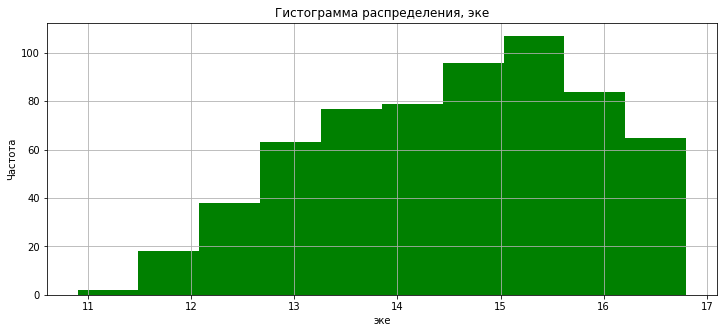

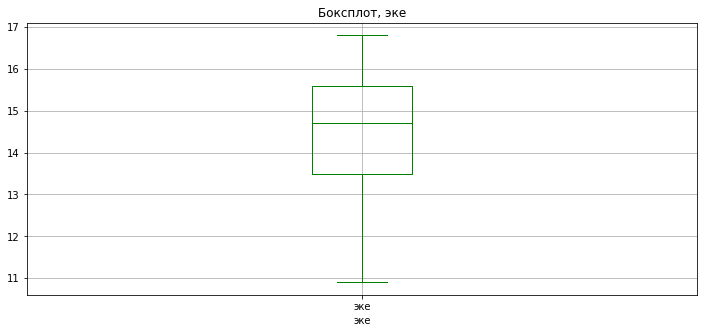

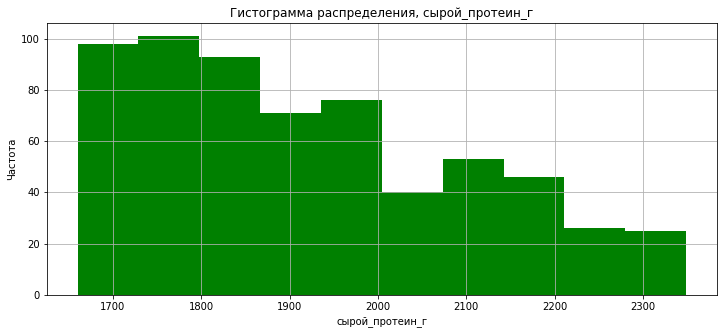

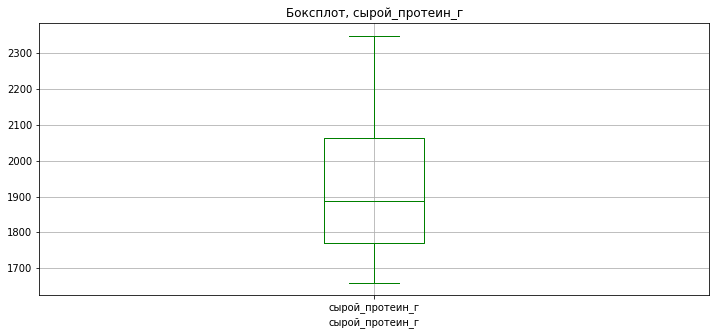

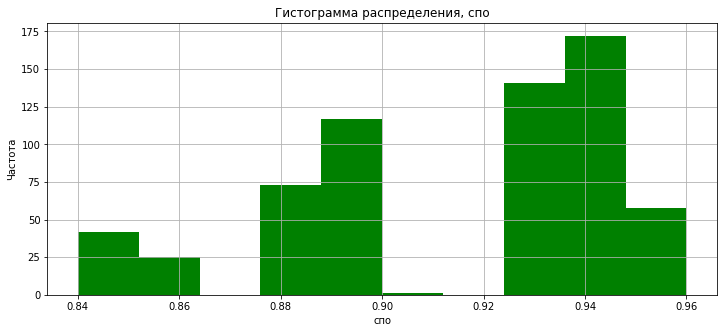

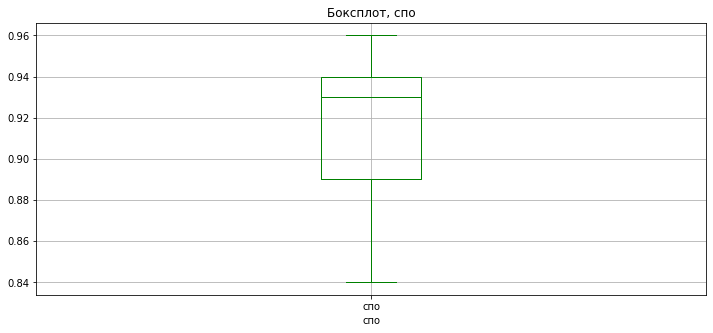

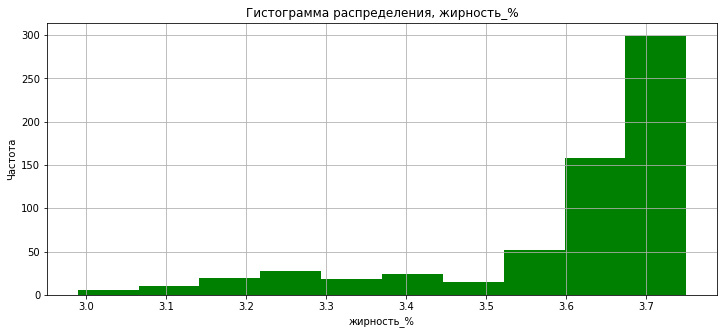

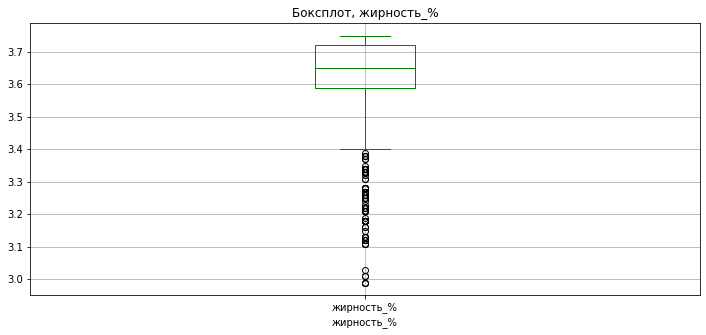

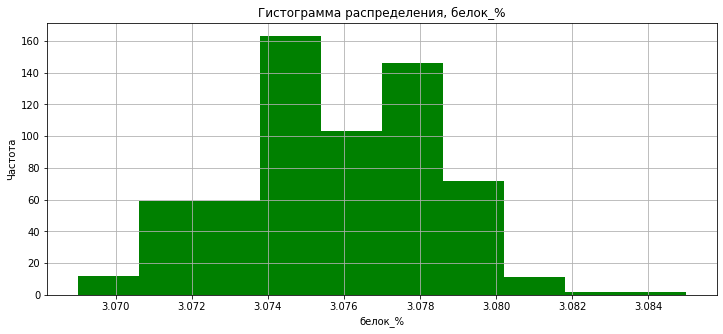

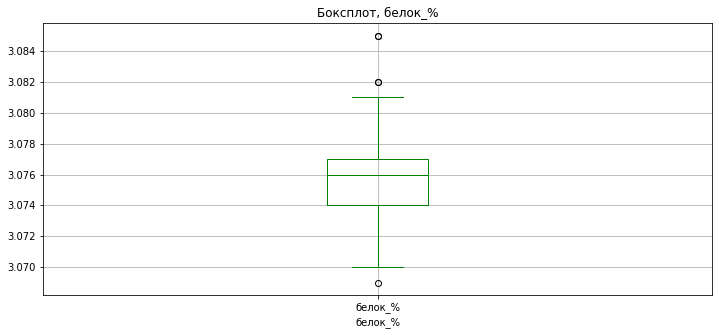

,id,удой_кг,эке,сырой_протеин_г,спо,жирность_%,белок_%,вкус_молока
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671,0.589825
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549,0.492257
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000,0.000000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000,0.000000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000,1.000000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000,1.000000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000,1.000000


''

In [17]:
for column in df_ferma_main.columns:
    if df_ferma_main[column].dtypes == 'float64' or column == 'сырой_протеин_г':
        df_ferma_main[column].hist(color = 'green',grid = True,figsize = (12,5))
        plt.title(f'Гистограмма распределения, {column}')
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.show()
        df_ferma_main.boxplot(column,color = 'green',grid = True,figsize = (12,5))
        plt.title(f'Боксплот, {column}')
        plt.xlabel(column)
        plt.show()
display(df_ferma_main.describe())
;

- В столбце 'удой' видим аномальные значения, исключим его и рассмотрим что изменится 
 - ЭКЕ не имеет аномалий
 - сырой протеин имеет скос
 - СПО группирется в трех интервалах,
 - жирность также характеризуется некоторыми аномалиями от 3.6 и выше
 - белок не имеет аномальных значений
 

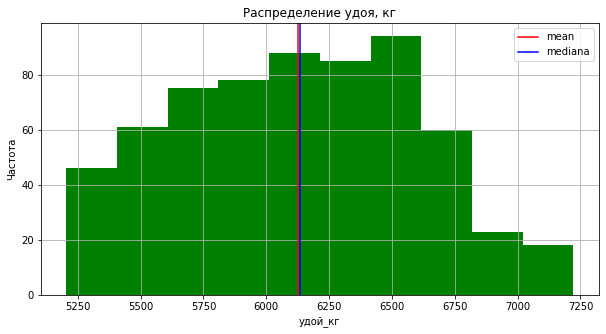

,id,удой_кг,эке,сырой_протеин_г,спо,жирность_%,белок_%,вкус_молока
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,315.474522,6125.968153,14.548726,1923.759554,0.913089,3.604268,3.075670,0.589172
std,181.475367,475.857053,1.301777,182.832816,0.032221,0.168093,0.002551,0.492376
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000,0.000000
25%,158.750000,5749.750000,13.500000,1771.750000,0.890000,3.590000,3.074000,0.000000
50%,315.500000,6132.500000,14.700000,1888.000000,0.930000,3.650000,3.076000,1.000000
75%,472.250000,6501.000000,15.600000,2062.250000,0.940000,3.720000,3.077000,1.000000
max,629.000000,7222.000000,16.800000,2349.000000,0.960000,3.750000,3.085000,1.000000


''

In [18]:
df_ferma_main = df_ferma_main[df_ferma_main['удой_кг'] < 45000]
df_ferma_main['удой_кг'].hist(figsize = (10,5),color = 'green')
plt.axvline(x=df_ferma_main['удой_кг'].mean(), color = 'red', label = 'mean')
plt.axvline(x=df_ferma_main['удой_кг'].median(), color = 'blue', label = 'mediana')
plt.title('Распределение удоя, кг')
plt.xlabel('удой_кг')
plt.ylabel('Частота')
plt.legend()
plt.show()
display(df_ferma_main.describe())
;

,жирность_%,белок_%
count,20.000000,20.000000
mean,3.577500,3.069500
std,0.126818,0.010339
min,3.340000,3.046000
25%,3.510000,3.064000
50%,3.590000,3.074000
75%,3.650000,3.076000
max,3.770000,3.081000


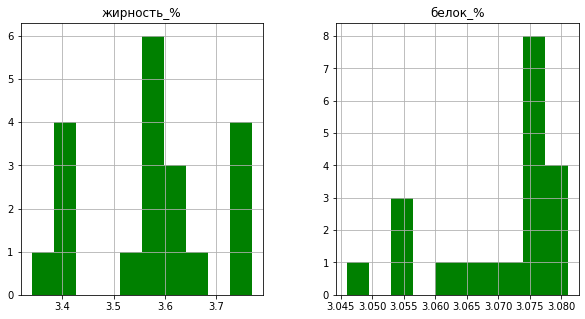

''

In [19]:
# изучим коров  "Экофермы"
df_cow_buy.hist(figsize = (10,5),color = 'green')
display(df_cow_buy.describe())
plt.show()
;

- Видно что распределения жирности и белка тоже имеют ненормальный вид, связано с объемом данных

**Далее рассмотрим категориальные признаки**

,id,белок_%,вкус_молока,жирность_%,спо,сырой_протеин_г,удой_кг,эке
порода,,,,,,,,
вис_бик_айдиал,279.387097,3.076274,0.586022,3.596935,0.911438,1922.620968,6099.405914,14.444624
рефлешнсоверинг,367.914062,3.074793,0.593750,3.614922,0.915488,1925.414062,6164.566406,14.700000


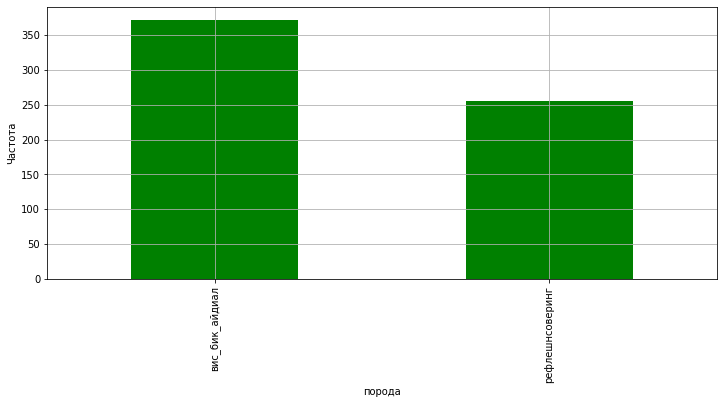

,id,белок_%,вкус_молока,жирность_%,спо,сырой_протеин_г,удой_кг,эке
тип_пастбища,,,,,,,,
равнинное,319.089928,3.075353,0.489209,3.608453,0.910899,1909.420863,6056.287770,14.405755
холмистое,312.602857,3.075923,0.668571,3.600943,0.914829,1935.148571,6181.314286,14.662286


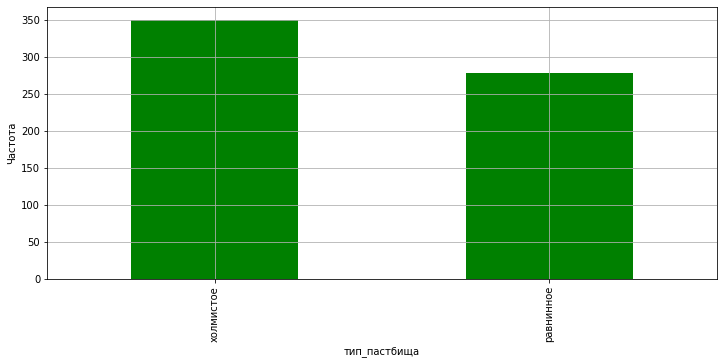

,id,белок_%,вкус_молока,жирность_%,спо,сырой_протеин_г,удой_кг,эке
порода_папы_быка,,,,,,,,
айдиал,287.899054,3.075817,0.589905,3.610284,0.920016,1925.082019,6310.899054,14.677603
соверин,343.581994,3.075521,0.588424,3.598135,0.906029,1922.411576,5937.469453,14.417363


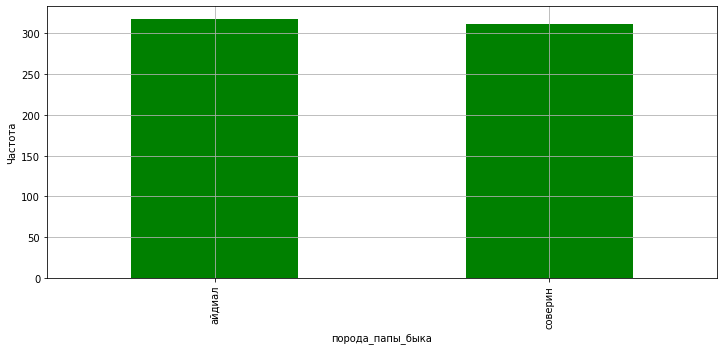

,id,белок_%,жирность_%,спо,сырой_протеин_г,удой_кг,эке
вкус_молока,,,,,,,
0,331.038760,3.075279,3.585310,0.905795,1891.248062,6061.717054,14.214729
1,304.621622,3.075943,3.617486,0.918176,1946.429730,6170.770270,14.781622


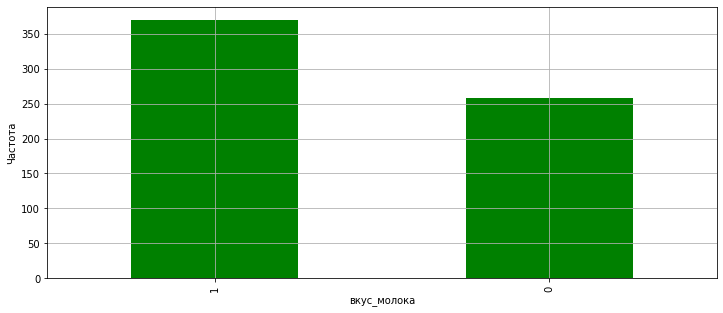

,id,белок_%,вкус_молока,жирность_%,спо,сырой_протеин_г,удой_кг,эке
возраст,,,,,,,,
более_2_лет,313.185328,3.075687,0.615830,3.643436,0.921274,1948.117761,6270.735521,14.881467
менее_2_лет,326.254545,3.075591,0.463636,3.419818,0.874545,1809.054545,5444.245455,12.981818


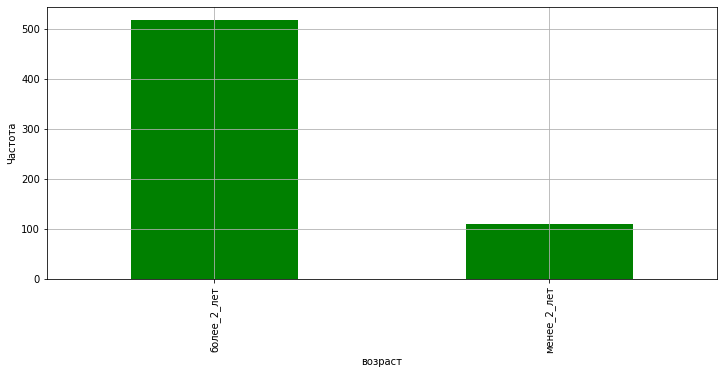

''

In [20]:
for column in df_ferma_main.columns:
    if df_ferma_main[column].dtypes == 'object' or column =='вкус_молока':
        df_ferma_main[column].value_counts().plot.bar(color = 'green',grid = True,figsize = (12,5))
        display(df_ferma_main.pivot_table(index=column, aggfunc='mean'))
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.show()
;

**Вывод:**
Данные по столбцу со своими коровами:
- В столбце 'удой' видим аномальные значения, исключим его и рассмотрим что изменится
- ЭКЕ не имеет аномалий
- сырой протеин имеет скос
- СПО группирется в трех интервалах,
- жирность также характеризуется некоторыми аномалиями от 3.6 и выше
- белок не имеет аномальных значений
- больше всего коров до 2 лет, что логично 
- по остальным категориальным признакам, частоты соспоставимы


## Корреляционный анализ

interval columns not set, guessing: ['удой_кг', 'эке', 'сырой_протеин_г', 'спо', 'жирность_%', 'белок_%', 'вкус_молока']


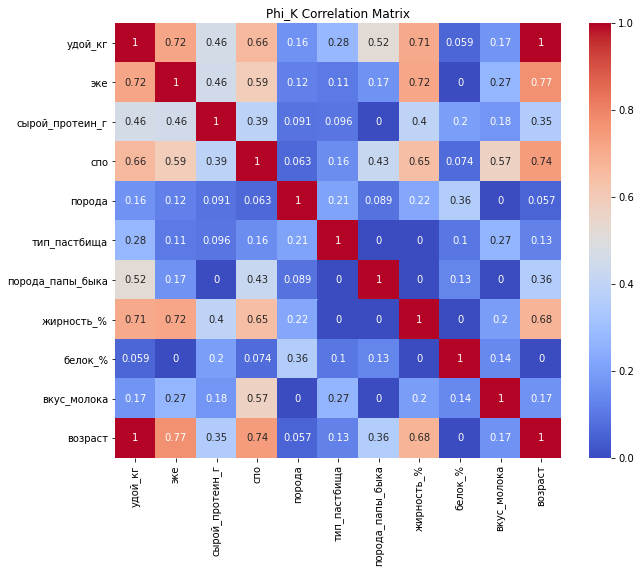

In [21]:
# Вычисление матрицы корреляции с использованием phik
for_heatmap = df_ferma_main.drop('id', axis=1)
corr_matrix = for_heatmap.phik_matrix()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

<AxesSubplot:title={'center':'Корреляция данных в таблице df_ferma_main'}>

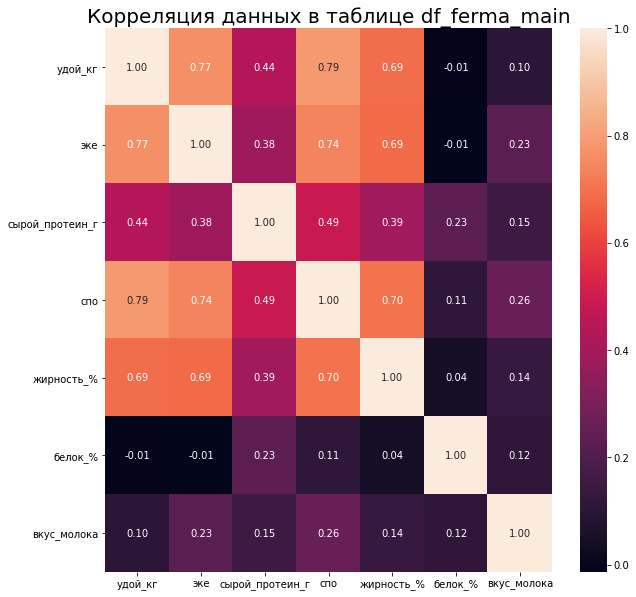

In [22]:
plt.figure(figsize=(10, 10))
plt.title('Корреляция данных в таблице df_ferma_main', fontsize=20)
for_heatmap = df_ferma_main.drop('id', axis=1)
sns.heatmap(for_heatmap.corr(method="spearman"), annot=True, fmt='.2f')


In [23]:
df_ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 628 entries, 0 to 628
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                628 non-null    int64  
 1   удой_кг           628 non-null    int64  
 2   эке               628 non-null    float64
 3   сырой_протеин_г   628 non-null    int64  
 4   спо               628 non-null    float64
 5   порода            628 non-null    object 
 6   тип_пастбища      628 non-null    object 
 7   порода_папы_быка  628 non-null    object 
 8   жирность_%        628 non-null    float64
 9   белок_%           628 non-null    float64
 10  вкус_молока       628 non-null    int64  
 11  возраст           628 non-null    object 
dtypes: float64(4), int64(4), object(4)
memory usage: 63.8+ KB


- Хорошая корреляционная связь наблюдается между:  Удой - ЭКЕ, Удой - Жирность, 
Удой - СПО

In [24]:
# строим графики функцией
def corr_plt(table_name,x,y):
    for column in table_name:
        if column not in [x,y,'id'] and table_name[column].dtypes=='object' or column =='вкус_молока':
            sns.scatterplot(data=table_name, x=x, y=y, hue = column)
            plt.show()
;

''

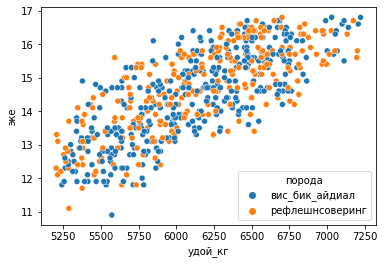

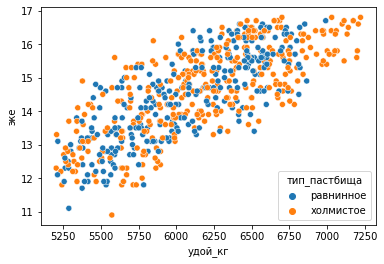

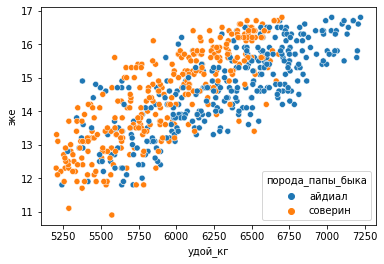

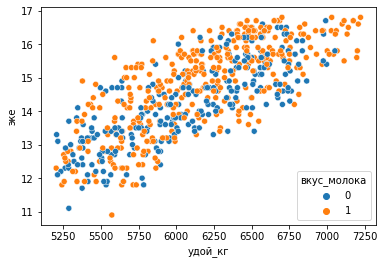

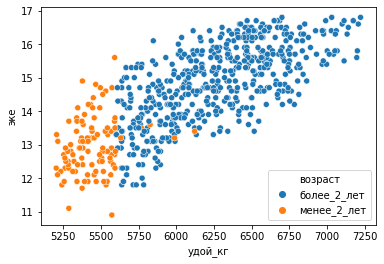

In [25]:
corr_plt(df_ferma_main,x="удой_кг",y="эке")

- Связь между ЭКЕ и Удоем для обеих пород одинаковая, прямо-пропорциональная с увеличением ЭКЕ растет удой 
- распределение ЭКЕ и Удоя в зависимости от пастбища сопоставима, наблюдаем что на холмистой местности удой и ЭКЕ немного выше
- потомство папы быка Айдала более чувствильно к увеличению удоя при увеличении ЭКЕ
- вкус молока также одинаково распределен в поле ЭКЕ-Удой
- ну и видим что коровы возрастом до 2 лет не могут достичь удоя в 6000 кг

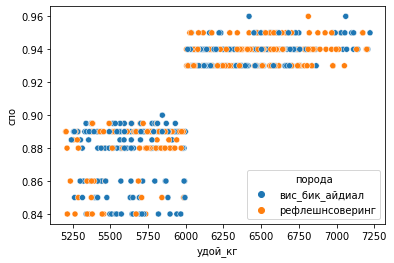

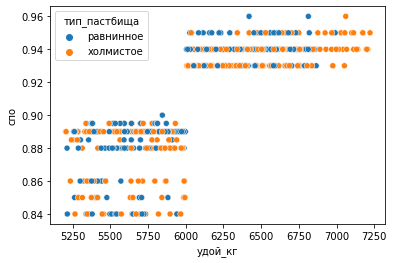

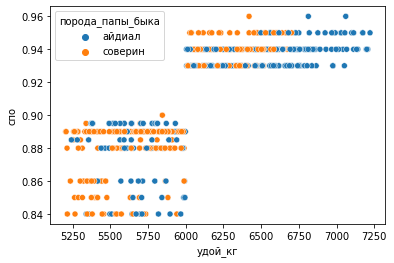

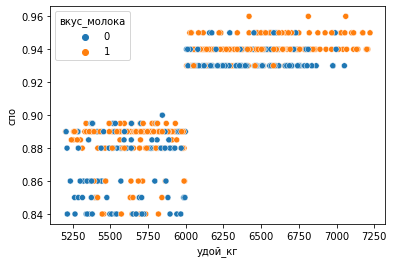

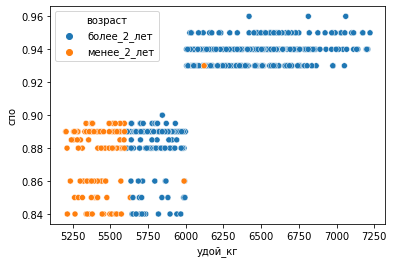

''

In [26]:
corr_plt(df_ferma_main,x="удой_кг",y="спо")
;

- видим что значения группируются в 3 интервалах, 
- более высокое СПО способствуеи более высоким Удоям, 
- на особей до 2х лет, он влияние не оказывает

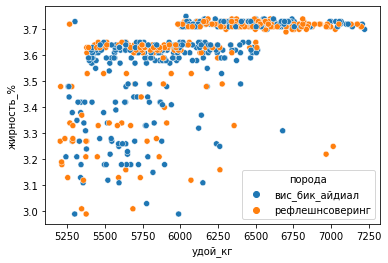

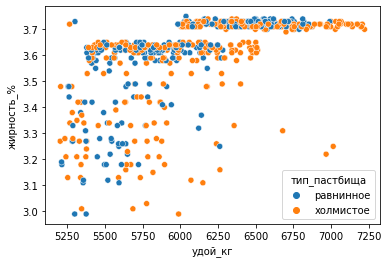

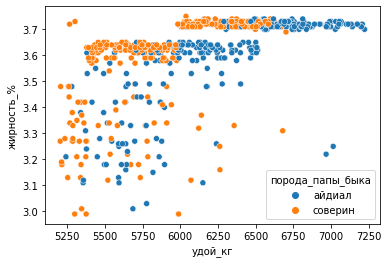

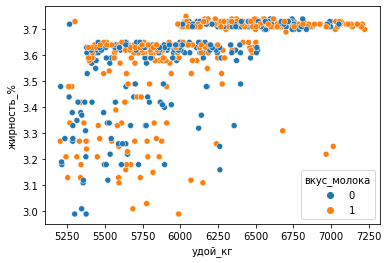

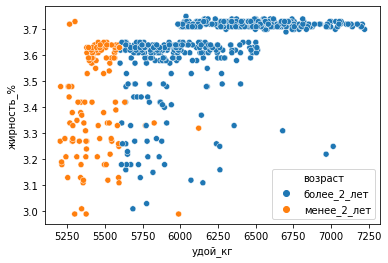

''

In [27]:
corr_plt(df_ferma_main,x="удой_кг",y="жирность_%")
;

- основной вывод что коровы в большинстве случаев дают молоко с жирностью 3.6, 3.7 %
- обе породы дают молоко сопостовимой жирности и удоя
- холмистая местность имеет чуть больший удой
- потомки айдиал дают более высокие удои при той же жирности 
- вкусное и невкусное молоко неразличается по жирности и удою
- коровы до 2 лет дают молоко  жирности 3.6 удой до 6000 не дотягивает


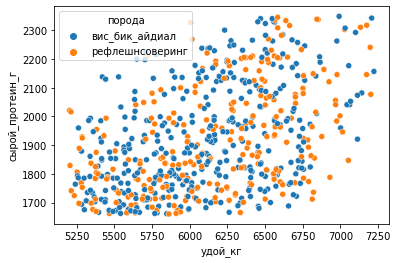

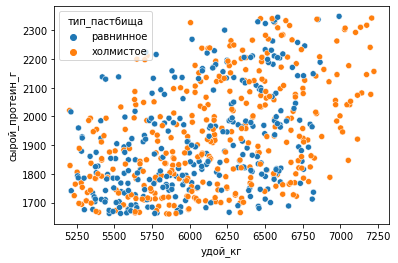

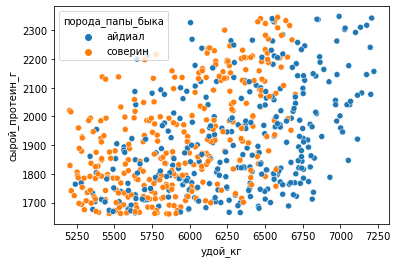

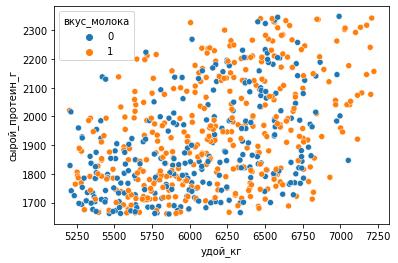

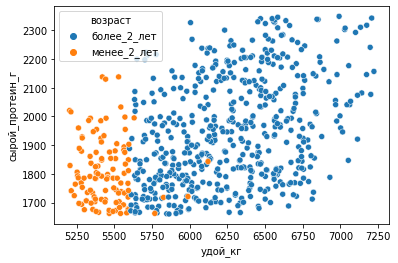

''

In [28]:
corr_plt(df_ferma_main,x="удой_кг",y="сырой_протеин_г")
;

- Между Сырым протеином в корме и Удоем связь слабая. 
- Независимо от других категориальных признаков, увеличение Сырого протеина в некоторой степени увеличивает Удой

**ВЫВОД**
- Наилучшая корреляция Удоя наблюдается с ЭКЕ, прямая линейная связь
- Также связь Удоя наблюдается с параметром Жирность и СПО, форма связи возможно нелинйная

Для модели лучше использовать параметры ЭКЕ, СПО, Жирность, Cырой протеин
- добавочно использовать категориальные признаки: Порода, Тип пастбища, Порода_папы_быка, возраст

Мультиколлениарность не наблюдается

## Обучение модели линейной регрессии

In [29]:
df = df_ferma_main[df_ferma_main.columns]

In [30]:
# Разделим данные на тренировочные и тестовые
RANDOM_STATE = 42

X = df.drop('удой_кг', axis=1)
y = df['удой_кг']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

display(X_train.info())
display(X_train.shape)
display(X_test.shape)
;

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 508 to 103
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                471 non-null    int64  
 1   эке               471 non-null    float64
 2   сырой_протеин_г   471 non-null    int64  
 3   спо               471 non-null    float64
 4   порода            471 non-null    object 
 5   тип_пастбища      471 non-null    object 
 6   порода_папы_быка  471 non-null    object 
 7   жирность_%        471 non-null    float64
 8   белок_%           471 non-null    float64
 9   вкус_молока       471 non-null    int64  
 10  возраст           471 non-null    object 
dtypes: float64(4), int64(3), object(4)
memory usage: 44.2+ KB


None

(471, 11)

(157, 11)

''

In [31]:
# рапределим названия столбцов по типам , для дальнешей работы с данными
num_cols = ['эке', 'спо','сырой_протеин_г']
сat_cols = ['порода','тип_пастбища', 'порода_папы_быка', 'возраст']
;

''

In [32]:
#количественные признаки необходимо масштабировать
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])
;

''

In [34]:
#категориальные признаки закодируем прямым методом
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[сat_cols])
X_test_ohe = encoder.transform(X_test[сat_cols])
encoder_col_names = encoder.get_feature_names_out()
display(encoder_col_names)
;

array(['порода_рефлешнсоверинг', 'тип_пастбища_холмистое',
       'порода_папы_быка_соверин', 'возраст_менее_2_лет'], dtype=object)

''

In [35]:
# Объеденим данные
X_train = np.concatenate((X_train_ohe, X_train_scaled), axis=1)
X_test = np.concatenate((X_test_ohe, X_test_scaled), axis=1)
;

''

In [36]:
# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions_1 = model_lr.predict(X_test)
;

''

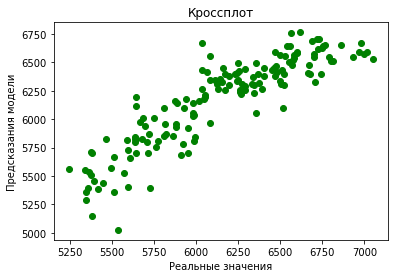

'Коэффициент детерминации - 0.7844078173416967'

''

In [37]:
plt.scatter(y_test, predictions_1, c ="green")
plt.xlabel("Реальные значения")
plt.ylabel('Предсказания модели')
plt.title('Кроссплот')
plt.show()
r2 = r2_score(y_test, predictions_1)  
display(f'Коэффициент детерминации - {r2}')
;

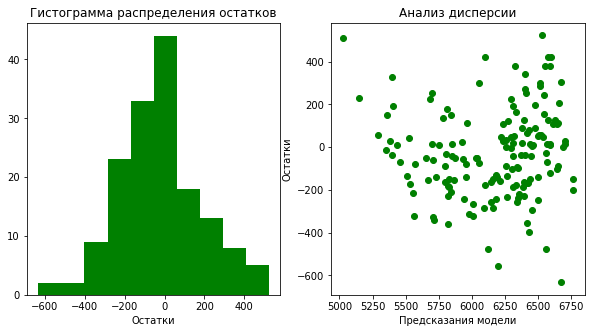

''

In [38]:
# проведем анализ остатков
residuals = y_test - predictions_1
# гистограмма и кроссплот
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, color ="green")
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_1, residuals, c ="green")
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()
;

**Вывод**
- С учетом связи междуисходными данными, можно сказать, что модель справляется достаточно неплохо с предсказаниями, r2 = 0.78 
- разброс остатков распределен нормально, без смещений, разброс удоя +- 600 кг, в пределах 10% от среднего, что также говорит об адекватности модели

Для улучшения модели можно перевести параметры СПО в категориальный тип и обучить модель на новых данных

**Обучение модели линейной регрессии 2**

In [39]:
# Преобразуем столбец СПО в категориальный бинарный признак, ждя этого возьмем отсечку 0.9
df = df_ferma_main[df_ferma_main.columns]
df.loc[df['спо']<0.91,['спо']] = 0
df.loc[df['спо']>=0.91,['спо']] = 1
df['спо'] = df['спо'].astype('int64')
df['эке'] = df['эке']**2
display(df['спо'].unique())
;

array([0, 1])

''

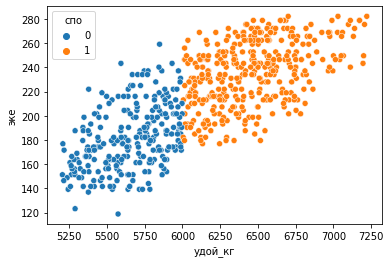

''

In [40]:
#  Посмотрим как изменилась связь
sns.scatterplot(data=df, x=df['удой_кг'], y=df['эке'], hue = df['спо'])
plt.show()
;

 - Как видно на графике зависимость параметров, наблюдается группировка значений по критерию СПО, 
 - границей можно считать 0.9 по спо, что дает удой выше 6000

In [41]:
RANDOM_STATE = 42

X = df.drop('удой_кг', axis=1)
y = df['удой_кг']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

X_train.info()
display(X_train.shape)
display(X_test.shape)
;

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 508 to 103
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                471 non-null    int64  
 1   эке               471 non-null    float64
 2   сырой_протеин_г   471 non-null    int64  
 3   спо               471 non-null    int64  
 4   порода            471 non-null    object 
 5   тип_пастбища      471 non-null    object 
 6   порода_папы_быка  471 non-null    object 
 7   жирность_%        471 non-null    float64
 8   белок_%           471 non-null    float64
 9   вкус_молока       471 non-null    int64  
 10  возраст           471 non-null    object 
dtypes: float64(3), int64(4), object(4)
memory usage: 44.2+ KB


(471, 11)

(157, 11)

''

In [42]:
cat_cols = ['порода', 'тип_пастбища', 'порода_папы_быка', 'спо', 'возраст']
num_cols = ['эке', 'сырой_протеин_г']

#кодируем категориальные признаки
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_cols])
X_test_ohe = encoder.transform(X_test[cat_cols])
encoder_col_names = encoder.get_feature_names_out()
encoder_col_names

array(['порода_рефлешнсоверинг', 'тип_пастбища_холмистое',
       'порода_папы_быка_соверин', 'спо_1', 'возраст_менее_2_лет'],
      dtype=object)

In [43]:
#масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])
;

''

In [44]:
# Объеденим данные
X_train = np.concatenate((X_train_ohe, X_train_scaled), axis=1)
X_test = np.concatenate((X_test_ohe, X_test_scaled), axis=1)
;

''

In [45]:
# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions_2 = model_lr.predict(X_test)
;

''

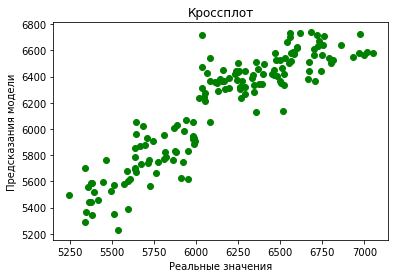

'Коэффициент детерминации - 0.8180879926867503'

''

In [46]:
#  Посмотрим как изменилась связь
plt.scatter(y_test, predictions_2, c ="green")
plt.xlabel("Реальные значения")
plt.ylabel('Предсказания модели')
plt.title('Кроссплот')
plt.show()
r2 = r2_score(y_test, predictions_2)  
display(f'Коэффициент детерминации - {r2}')
;

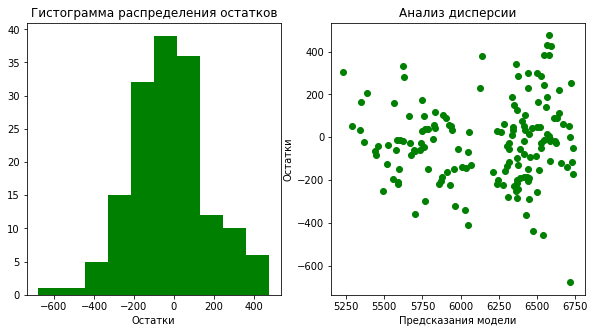

''

In [47]:
# проведем анализ остатков
residuals = y_test - predictions_2
# гистограмма и кроссплот
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, color ="green")
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_2, residuals, c ="green")
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()
;

**Вывод**
- Связь улучшилась видно по значениям и разбросу даннывых +  r2 = 0.82
- разброс остатков распределен нормально, без смещений, разброс удоя +- 600 кг,
- распределение остатков стало ближе к нормальному распределению


In [48]:
df = df_ferma_main[df_ferma_main.columns]
df.loc[df['спо']<0.91,['спо']] = 0
df.loc[df['спо']>=0.91,['спо']] = 1
df['спо'] = df['спо'].astype('int64')
df['эке'] = df['эке']**2
display(df['спо'].unique())
;

array([0, 1])

''

In [49]:
# Добавим в анализ данные про отцов

df = df.merge(df_ferma_dad, how  ='inner', on = 'id')
display(df.head(5))
;

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст,имя_папы
0,1,5863,201.64,1743,0,вис_бик_айдиал,равнинное,айдиал,3.58,3.076,1,более_2_лет,буйный
1,2,5529,163.84,2138,0,вис_бик_айдиал,равнинное,соверин,3.54,3.079,1,менее_2_лет,соловчик
2,3,5810,196.00,1854,0,рефлешнсоверинг,холмистое,соверин,3.59,3.074,0,более_2_лет,барин
3,4,5895,153.76,2012,0,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,0,более_2_лет,буйный
4,5,5302,163.84,1675,0,вис_бик_айдиал,равнинное,соверин,3.73,3.073,1,менее_2_лет,барин


''

In [50]:
RANDOM_STATE = 42

X = df.drop('удой_кг', axis=1)
y = df['удой_кг']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

X_train.info()
display(X_train.shape)
display(X_test.shape)
;

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 507 to 102
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                471 non-null    int64  
 1   эке               471 non-null    float64
 2   сырой_протеин_г   471 non-null    int64  
 3   спо               471 non-null    int64  
 4   порода            471 non-null    object 
 5   тип_пастбища      471 non-null    object 
 6   порода_папы_быка  471 non-null    object 
 7   жирность_%        471 non-null    float64
 8   белок_%           471 non-null    float64
 9   вкус_молока       471 non-null    int64  
 10  возраст           471 non-null    object 
 11  имя_папы          471 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 47.8+ KB


(471, 12)

(157, 12)

''

In [51]:
cat_cols = ['порода', 'тип_пастбища', 'порода_папы_быка', 'спо', 'имя_папы', 'возраст']
num_cols = ['эке', 'сырой_протеин_г']

# кодируем категориальные признаки
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_cols])
X_test_ohe = encoder.transform(X_test[cat_cols])
encoder_col_names = encoder.get_feature_names_out()
display(encoder_col_names)
;

array(['порода_рефлешнсоверинг', 'тип_пастбища_холмистое',
       'порода_папы_быка_соверин', 'спо_1', 'имя_папы_буйный',
       'имя_папы_геркулес', 'имя_папы_соловчик', 'возраст_менее_2_лет'],
      dtype=object)

''

In [52]:
# масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])
;

''

In [53]:
# Объеденим данные
X_train = np.concatenate((X_train_ohe, X_train_scaled), axis=1)
X_test = np.concatenate((X_test_ohe, X_test_scaled), axis=1)
;

''

In [54]:
# обучение модели и получение предсказаний на тестовых данных
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions_3 = model_lr.predict(X_test)
;

''

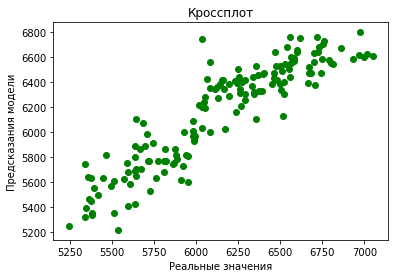

'Коэффициент детерминации - 0.8247542745210408'

''

In [55]:
#  Посмотрим как изменилась связь
plt.scatter(y_test, predictions_3, c ="green")
plt.xlabel("Реальные значения")
plt.ylabel('Предсказания модели')
plt.title('Кроссплот')
plt.show()
r2 = r2_score(y_test, predictions_3)  
display(f'Коэффициент детерминации - {r2}')
;

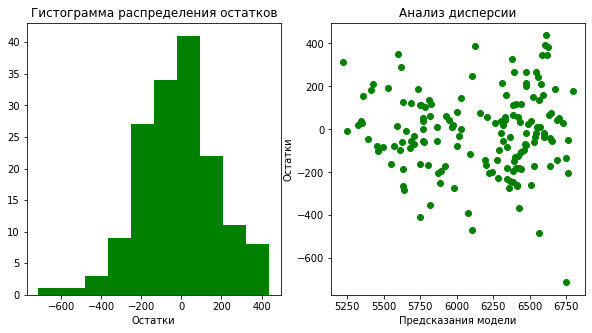

''

In [56]:
# проведем анализ остатков
residuals = y_test - predictions_3
# гистограмма и кроссплот
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, color ="green")
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions_3, residuals, c ="green")
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()
;

- r2 увеличился и стал 0,82 
- распределение остатков: - смещения нет, модель адекватно оценивает удои 
- распределение остатков сжалось ближе к 0

In [57]:
display(model_lr.coef_)
display(model_lr.intercept_)
;

array([  14.91963448,   50.94331021,   44.03330527,  353.77982896,
        302.17959627,  333.92915102,   24.6844087 , -192.54870875,
        162.38779236,   52.03531718])

5756.290300706801

''

In [58]:
# функция для расчета метрик
def ml_metrics(model_name, real, predict):
    mse = mean_squared_error(real, predict)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real, predict)
    print(model_name, '- MAE:',mae, ', MSE:', mse, ', RMSE:', rmse)

In [59]:
# Метрики для первой модели лин регрессии
ml_metrics('Model_1', y_test, predictions_1)

Model_1 - MAE: 164.24194463474925 , MSE: 43887.015009660514 , RMSE: 209.4922791170608


In [60]:
# Метрики для второй модели лин регрессии
ml_metrics('Model_2', y_test, predictions_2)

Model_2 - MAE: 149.03965222364593 , MSE: 37030.91131113694 , RMSE: 192.4341739690145


In [61]:
# Метрики для третьей модели лин регрессии
ml_metrics('Model_3', y_test, predictions_3)

Model_3 - MAE: 146.1630244536231 , MSE: 35673.88988618191 , RMSE: 188.8753289505591


- По расчитанным метрикам делаем вывод, что 3-я модель лучше всего прогнозирует данные, в среднем ошибается на 189кг
- рассчитаем доверительный интервал

In [62]:
p_int = st.norm.interval(0.95, loc=np.mean(predictions_3), scale=st.sem(predictions_3))
print('95% доверительный интервал =', p_int)


95% доверительный интервал = (6092.340075854288, 6221.3750700583805)


**Далее будем использовать нашу модель_3 для прогноза на тестовых данных**

In [63]:
display(df_cow_buy.head())
;

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет
1,вис_бик_айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет


''

In [64]:
df_test = df_cow_buy[df_cow_buy.columns]
;

''

In [65]:
# неоюходимо учесть изменение питания
df_test['эке'] = df_ferma_main['эке'].mean()*1.05
df_test['спо'] = df_ferma_main['спо'].mean()*1.05
df_test['сырой_протеин_г'] = df_ferma_main['сырой_протеин_г'].mean()*1.05
;

''

In [66]:
display(df_test.head())
;

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст,эке,спо,сырой_протеин_г
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532
1,вис_бик_айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532


''

In [67]:
# подготовим данные для МО
df_test.loc[df['спо']<0.91, ['спо']] = 0
df_test.loc[df['спо']>=0.91, ['спо']] = 1
df_test['спо'] = df_test['спо'].astype('int64')
df_test['эке'] = df_test['эке']**2
;

''

In [68]:
cat_cols = ['порода', 'тип_пастбища', 'порода_папы_быка', 'спо','имя_папы', 'возраст']
num_cols = ['эке', 'сырой_протеин_г']

# кодируем категориальные признаки
X_test_ohe = encoder.transform(df_test[cat_cols])
encoder_col_names = encoder.get_feature_names_out()
display(encoder_col_names)
;

array(['порода_рефлешнсоверинг', 'тип_пастбища_холмистое',
       'порода_папы_быка_соверин', 'спо_1', 'имя_папы_буйный',
       'имя_папы_геркулес', 'имя_папы_соловчик', 'возраст_менее_2_лет'],
      dtype=object)

''

In [69]:
# масштабируем количественные признаки
X_test_scaled = scaler.transform(df_test[num_cols])
;

''

In [70]:
# Объеденим данные
X_test = np.concatenate((X_test_ohe, X_test_scaled), axis=1)
;

''

In [71]:
# предсказания на тестовых данных
predictions_df_test = model_lr.predict(X_test)
display(predictions_df_test)
;

array([6256.13946786, 6024.93119941, 5930.21994637, 6239.30954758,
       6188.36623737, 6071.60038863, 6256.13946786, 6571.25973712,
       6283.99977532, 6046.76083883, 5990.9280308 , 6617.92892634,
       6609.91929681, 6127.4747423 , 6283.99977532, 6593.08937654,
       5990.9280308 , 6425.38021759, 6217.47990816, 6542.14606633])

''

In [72]:
# Запишем данные в датафрейм
predict = df_test[df_test.columns]
predict['удой_кг'] = predictions_df_test
display(predict)
;

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст,эке,спо,сырой_протеин_г,удой_кг
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,233.361138,0,2019.947532,6256.139468
1,вис_бик_айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,233.361138,0,2019.947532,6024.931199
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,233.361138,0,2019.947532,5930.219946
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,233.361138,0,2019.947532,6239.309548
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,233.361138,0,2019.947532,6188.366237
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,менее_2_лет,233.361138,0,2019.947532,6071.600389
6,вис_бик_айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,233.361138,0,2019.947532,6256.139468
7,вис_бик_айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,233.361138,1,2019.947532,6571.259737
8,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,233.361138,1,2019.947532,6283.999775
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,233.361138,0,2019.947532,6046.760839


''

Вывод
- как видно по прогнозным данным, большинство коров при коррекции питания дают удой выше 6000

## Обучение модели логистической регрессии

In [73]:
df_lg = df_ferma_main[df_ferma_main.columns]
display(df_lg.head())
;

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,вис_бик_айдиал,равнинное,айдиал,3.58,3.076,1,более_2_лет
1,2,5529,12.8,2138,0.890,вис_бик_айдиал,равнинное,соверин,3.54,3.079,1,менее_2_лет
2,3,5810,14.0,1854,0.885,рефлешнсоверинг,холмистое,соверин,3.59,3.074,0,более_2_лет
3,4,5895,12.4,2012,0.885,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,0,более_2_лет
4,5,5302,12.8,1675,0.885,вис_бик_айдиал,равнинное,соверин,3.73,3.073,1,менее_2_лет


''

In [74]:
# необходимо также преобразовать данные для улучшения корреляции
df_lg.loc[df_lg['спо']<0.91, ['спо']] = 0
df_lg.loc[df_lg['спо']>=0.91, ['спо']] = 1
df_lg['спо'] = df_lg['спо'].astype('int64')
df_lg['эке'] = df_lg['эке']**2
df_lg.head()

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст
0,1,5863,201.64,1743,0,вис_бик_айдиал,равнинное,айдиал,3.58,3.076,1,более_2_лет
1,2,5529,163.84,2138,0,вис_бик_айдиал,равнинное,соверин,3.54,3.079,1,менее_2_лет
2,3,5810,196.00,1854,0,рефлешнсоверинг,холмистое,соверин,3.59,3.074,0,более_2_лет
3,4,5895,153.76,2012,0,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,0,более_2_лет
4,5,5302,163.84,1675,0,вис_бик_айдиал,равнинное,соверин,3.73,3.073,1,менее_2_лет


In [75]:
# Добавим стобец с именем отца
df_lg = df_lg.merge(df_ferma_dad, how  ='inner', on = 'id')
display(df_lg.head())
;

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст,имя_папы
0,1,5863,201.64,1743,0,вис_бик_айдиал,равнинное,айдиал,3.58,3.076,1,более_2_лет,буйный
1,2,5529,163.84,2138,0,вис_бик_айдиал,равнинное,соверин,3.54,3.079,1,менее_2_лет,соловчик
2,3,5810,196.00,1854,0,рефлешнсоверинг,холмистое,соверин,3.59,3.074,0,более_2_лет,барин
3,4,5895,153.76,2012,0,рефлешнсоверинг,холмистое,айдиал,3.40,3.075,0,более_2_лет,буйный
4,5,5302,163.84,1675,0,вис_бик_айдиал,равнинное,соверин,3.73,3.073,1,менее_2_лет,барин


''

In [76]:
RANDOM_STATE = 42

X = df_lg.drop('вкус_молока', axis=1)
y = df_lg['вкус_молока']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE)

X_train.info()
display(X_train.shape)
display(X_test.shape)
;

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 507 to 102
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                471 non-null    int64  
 1   удой_кг           471 non-null    int64  
 2   эке               471 non-null    float64
 3   сырой_протеин_г   471 non-null    int64  
 4   спо               471 non-null    int64  
 5   порода            471 non-null    object 
 6   тип_пастбища      471 non-null    object 
 7   порода_папы_быка  471 non-null    object 
 8   жирность_%        471 non-null    float64
 9   белок_%           471 non-null    float64
 10  возраст           471 non-null    object 
 11  имя_папы          471 non-null    object 
dtypes: float64(3), int64(4), object(5)
memory usage: 47.8+ KB


(471, 12)

(157, 12)

''

In [77]:
cat_cols = ['порода', 'тип_пастбища', 'порода_папы_быка', 'спо','имя_папы', 'возраст']
num_cols = ['эке', 'сырой_протеин_г','жирность_%', 'белок_%']

# кодируем категориальные признаки
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
X_train_ohe = encoder.fit_transform(X_train[cat_cols])
X_test_ohe = encoder.transform(X_test[cat_cols])
encoder_col_names = encoder.get_feature_names_out()
display(encoder_col_names)
;

array(['порода_рефлешнсоверинг', 'тип_пастбища_холмистое',
       'порода_папы_быка_соверин', 'спо_1', 'имя_папы_буйный',
       'имя_папы_геркулес', 'имя_папы_соловчик', 'возраст_менее_2_лет'],
      dtype=object)

''

In [78]:
# масштабируем количественные признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])
;

''

In [79]:
# Объеденим данные
X_train = np.concatenate((X_train_ohe, X_train_scaled), axis=1)
X_test = np.concatenate((X_test_ohe, X_test_scaled), axis=1)
;

''

In [80]:
# обучим модель логистической регрессии и получим предсказания на тестовых данных
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
display(y_pred)
;

array([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0])

''

In [81]:
# рассчитаем метрики для логистической регрессиии
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_pred, y_test)
precision = precision_score(y_pred, y_test)
print('accuracy: ',round(acc ,2))
print('recall: ',round(recall ,2))
print('precision: ',round(precision,2))
;

accuracy:  0.63
recall:  0.62
precision:  0.86


''

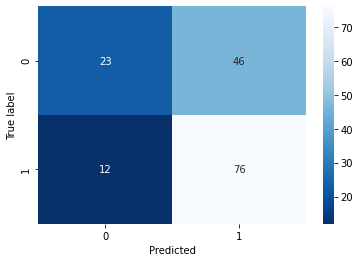

In [82]:
# построи матрицу ошибок, для оценки их вида
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

- Cогласно матрицы ошибок, модель гораздо чаще ошибается в том, что молоко будет вкусным, в случае когда оно на самом деле не вкусное (46раз, дает ложноположительный результат), тоесть совершает ошибку первого рода и 12 раз совершает ишибку второго рода 

**Для нашей задачи необходимо чтобы модель реже давала ошибки первого рода**
- для уменьшения ошибок первого рода необходимо оптимизировать параметр  precision, подобрать такое значение которое минимизирует ошибки первого рода

In [83]:
# для изменения точности модели необходимо изменить пороговое значение, рассмотрим разные варианты порога
y_proba = clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba),
                    columns = ['y_tests', 'y_proba']).sort_values(by='y_proba',ascending=False)

print(data.head())
;

     y_tests   y_proba
85         1  0.861100
110        1  0.842725
66         1  0.841351
51         1  0.839460
8          1  0.817165


''

In [84]:
thresholds = [round(i,2) for i in np.linspace(0.65,0.85,num = 20,endpoint=False)]
print(thresholds) 

[0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84]


In [85]:
# список новых колонок
columns = []
# добавьте столбцы с новыми предсказаниями в таблицу
for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x >= i else 0 )
display(data.head(5))

;

,y_tests,y_proba,y_pred_0.65,y_pred_0.66,y_pred_0.67,y_pred_0.68,y_pred_0.69,y_pred_0.7,y_pred_0.71,y_pred_0.72,...,y_pred_0.75,y_pred_0.76,y_pred_0.77,y_pred_0.78,y_pred_0.79,y_pred_0.8,y_pred_0.81,y_pred_0.82,y_pred_0.83,y_pred_0.84
85,1,0.861100,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
110,1,0.842725,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
66,1,0.841351,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
51,1,0.839460,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
8,1,0.817165,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,0


''

In [86]:
# Рассчитаем для всех пороговых значений
por = []
por = pd.DataFrame(columns=['Порог', 'Precision'])
t = 0
for i in data.columns[2:]:
    precision = precision_score(data['y_tests'],data[i])
    por.loc[t] = [i, precision]
    t = t+1
display(por)
;

,Порог,Precision
0,y_pred_0.65,0.769231
1,y_pred_0.66,0.766667
2,y_pred_0.67,0.789474
3,y_pred_0.68,0.807692
4,y_pred_0.69,0.816327
5,y_pred_0.7,0.822222
6,y_pred_0.71,0.825000
7,y_pred_0.72,0.815789
8,y_pred_0.73,0.828571
9,y_pred_0.74,0.866667


''

- Пороговое значение актуальное для нас = 0.81, 
при данном значении порога минимизируется для нас ошибки первого рода

**Применим модель к данным**

In [87]:
df_cow_buy_test = df_cow_buy[df_cow_buy.columns]
display(df_cow_buy_test.head(5))
;

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет
1,вис_бик_айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет


''

In [88]:
# добавим столбцы
df_cow_buy_test['эке'] = df['эке'].mean()*1.05
df_cow_buy_test['спо'] = df['спо'].mean()*1.05
df_cow_buy_test['сырой_протеин_г'] = df['сырой_протеин_г'].mean()*1.05
df_cow_buy_test.loc[df['спо']<0.91, ['спо']] = 0
df_cow_buy_test.loc[df['спо']>=0.91, ['спо']] = 1
display(df_cow_buy_test.head(5))
;

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст,эке,спо,сырой_протеин_г
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,224.025225,0.0,2019.947532
1,вис_бик_айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,224.025225,0.0,2019.947532
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,224.025225,0.0,2019.947532
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,224.025225,0.0,2019.947532
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,224.025225,0.0,2019.947532


''

In [89]:
cat_cols = ['порода', 'тип_пастбища', 'порода_папы_быка', 'спо','имя_папы', 'возраст']
num_cols = ['эке', 'сырой_протеин_г','жирность_%', 'белок_%']

# кодируем категориальные признаки
df_cow_buy_test_ohe = encoder.transform(df_cow_buy_test[cat_cols])
encoder_col_names = encoder.get_feature_names_out()
encoder_col_names
display(encoder_col_names)
;

array(['порода_рефлешнсоверинг', 'тип_пастбища_холмистое',
       'порода_папы_быка_соверин', 'спо_1', 'имя_папы_буйный',
       'имя_папы_геркулес', 'имя_папы_соловчик', 'возраст_менее_2_лет'],
      dtype=object)

''

In [90]:
# Масштабируем количественные признаки
df_cow_buy_test_scaled = scaler.transform(df_cow_buy_test[num_cols])
;

''

In [91]:
# Объеденим данные
X_test = np.concatenate((df_cow_buy_test_ohe, df_cow_buy_test_scaled), axis=1)
;

''

In [92]:
# Функция для изменения порога
def custom_predict(X, threshold):
    probs = clf.predict_proba(X)
    return (probs[:, 1] > threshold).astype(int)    

In [93]:
new_preds = custom_predict(X=X_test, threshold=0.81) 
display(new_preds)
;

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

''

In [94]:
predict['вкус'] = new_preds
display(predict)
;

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст,эке,спо,сырой_протеин_г,удой_кг,вкус
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,233.361138,0,2019.947532,6256.139468,1
1,вис_бик_айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,233.361138,0,2019.947532,6024.931199,0
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,233.361138,0,2019.947532,5930.219946,0
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,233.361138,0,2019.947532,6239.309548,0
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,233.361138,0,2019.947532,6188.366237,0
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.63,3.053,менее_2_лет,233.361138,0,2019.947532,6071.600389,0
6,вис_бик_айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,233.361138,0,2019.947532,6256.139468,1
7,вис_бик_айдиал,равнинное,соверин,буйный,3.57,3.079,более_2_лет,233.361138,1,2019.947532,6571.259737,0
8,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,233.361138,1,2019.947532,6283.999775,0
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,233.361138,0,2019.947532,6046.760839,1


''

In [95]:
# Выберем коров которые подходят по нашим условиям
display(predict.query('удой_кг>=6000 and вкус != 0'))
;

,порода,тип_пастбища,порода_папы_быка,имя_папы,жирность_%,белок_%,возраст,эке,спо,сырой_протеин_г,удой_кг,вкус
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,233.361138,0,2019.947532,6256.139468,1
6,вис_бик_айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,233.361138,0,2019.947532,6256.139468,1
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.079,менее_2_лет,233.361138,0,2019.947532,6046.760839,1


''

## Итоговые выводы

**Выполнили первый шаг подготовки данных**

- Загрузили данные, в трех таблицах 
       - первая таблица содержит 634 строки и 12 столбцов, 
            обнаружил 5 явных дубликатов и ни одного пропуска
       - вторая таблица содержит 629 строк и 2 столбца, 
            0 явных дубликатов и ни одного пропуска
       - третья таблица содержит 20 строк и 6 столбцов, 
            
       Обработали названия столбцов и некоторые значения в самих столбцах, для удобства дальнейшего анализа. 
       Требуется некоторое преобразование  типов данных во всех таблицах.
       На первый взгляд данные выглядят корректно и их достаточно для дальнейшей работы.

**Выполнили предобработку данных** 
    
    - удалили явные дубликаты
    - проверили на неявные (в столбце "тип пастбища" устранили неявный дубликат)
    - преобразовали типы данных в корректные
    - подготовили данные к дальнешему анализу

**Выполнили исследовательский анализ данных и выяснили, что**

    - В столбце 'удой' видим аномальные значения, исключим его и рассмотрим что изменится
    - ЭКЕ не имеет аномалий
    - сырой протеин имеет скос
    - СПО группирется в трех интервалах,
    - жирность также характеризуется некоторыми аномалиями от 3.6 и выше
    - белок не имеет аномальных значений
    - больше всего коров до 2 лет, что логично 
    - по остальным категориальным признакам, частоты соспоставимы

**Корреляционный анализ**
    
    - Наилучшая корреляция Удоя наблюдается с ЭКЕ, прямая линейная связь
    - Также связь Удоя наблюдается с параметром Жирность и СПО, форма связи возможно нелинйная

    Для модели лучше использовать параметры ЭКЕ, СПО, Жирность, Cырой протеин
    - добавочно использовать категориальные признаки: Порода, Тип пастбища, Порода_папы_быка, возраст

    Мультиколлениарность не наблюдается

**Обучение моделей**

        - Обучили 3 модели линейной регрессии с разными параметрами, получили результирующий r2 = 0.82,
        - проанализировав разные метрики выбрали лучшую модель и применили ее на тестовых данных для получения прогноза удоя 
        - дальше применили логистическую регрессию для определения вкуса молока в тестовой выборке,
        - обучили модель, рассчитали метрики
        - для улучшения модели изменили пороговое значение на 0,81, длятого чтобы минимизировать ошибки первого рода, 
        
**Результат**

- Определили 3 объекта, которые подходят по нашим критериям для покупки